In [3]:
import pandas as pd

df = pd.read_csv('/Users/anhnguyendo/Documents/Python machine learning/US CPI project/us-consumer-spending-inflation/data/processed/merged_df.csv')
df.head()

,Unnamed: 0,realtime_start,date,value_cpi,value_pce,value_dspi,value_real_pce,saving_rate,value_pcepi,cpi_pct_change,pcepi_pct_change,dspi_pct_cahnge,dspi_pct_change
0,24,2025-04-21,2012-01-01,227.842,10896.8,12175.6,11814.170326,0.029685,92.235,3.008766,2.061479,4.401362,4.401362
1,25,2025-04-21,2012-02-01,228.329,10987.2,12261.2,11895.543718,0.029822,92.364,2.898178,2.025848,4.544602,4.544602
2,26,2025-04-21,2012-03-01,228.807,10993.9,12319.4,11882.599626,0.035456,92.521,2.582875,2.044845,4.896844,4.896844
3,27,2025-04-21,2012-04-01,229.187,11018.5,12382.9,11891.194785,0.039708,92.661,2.273163,1.965337,5.169778,5.169778
4,28,2025-04-21,2012-05-01,228.713,11006.8,12365.1,11866.530106,0.040321,92.755,1.737943,1.826745,4.831626,4.831626


In [12]:
import numpy as np
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")


In [8]:
def sarima_grid_search(y, seasonal_period=12, p_range=(0, 3), d_range=(0, 2), q_range=(0, 3),
                       P_range=(0, 2), D_range=(0, 2), Q_range=(0, 2)):
    best_score, best_cfg = float("inf"), None
    results = []

    pdq = list(itertools.product(range(*p_range), range(*d_range), range(*q_range)))
    seasonal_pdq = list(itertools.product(range(*P_range), range(*D_range), range(*Q_range)))

    for param in pdq:
        for seasonal_param in seasonal_pdq:
            try:
                model = SARIMAX(y, order=param,
                                seasonal_order=seasonal_param + (seasonal_period,),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
                results_fit = model.fit(disp=False)
                aic = results_fit.aic
                results.append((param, seasonal_param, aic))
                if aic < best_score:
                    best_score = aic
                    best_cfg = (param, seasonal_param)
            except:
                continue

    results_df = pd.DataFrame(results, columns=["pdq", "seasonal_pdq", "AIC"]).sort_values("AIC")
    return best_cfg, results_df


In [15]:
# Assuming 'df' is your dataframe and 'inflation_rate' is the target column
df.index = pd.to_datetime(df.index)
y = df['cpi_pct_change'].dropna()

best_cfg, results_df = sarima_grid_search(
    y,
    seasonal_period=12,
    p_range=(0, 3),
    d_range=(0, 2),
    q_range=(0, 3),
    P_range=(0, 2),
    D_range=(0, 2),
    Q_range=(0, 2)
)

print("Best SARIMA configuration:", best_cfg)
print(results_df.head())



Best SARIMA configuration: ((2, 1, 1), (0, 0, 1))
           pdq seasonal_pdq        AIC
129  (2, 1, 1)    (0, 0, 1)  30.280192
89   (1, 1, 2)    (0, 0, 1)  30.857246
93   (1, 1, 2)    (1, 0, 1)  31.211558
141  (2, 1, 2)    (1, 0, 1)  31.322556
137  (2, 1, 2)    (0, 0, 1)  31.800328


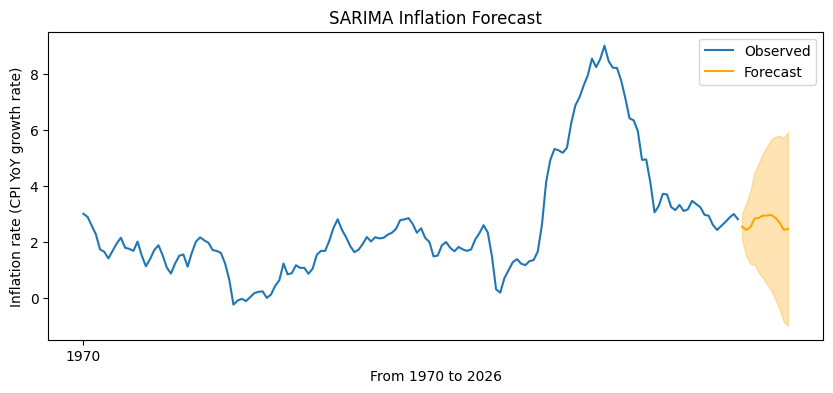

In [17]:
model = SARIMAX(y,
                order=best_cfg[0],
                seasonal_order=best_cfg[1] + (12,),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()
forecast = results.get_forecast(steps=12)
forecast_ci = forecast.conf_int()

# Plot
plt.figure(figsize=(10, 4))
plt.plot(y, label='Observed')
plt.plot(forecast.predicted_mean, label='Forecast', color='orange')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='orange', alpha=0.3)
plt.legend()
plt.title("SARIMA Inflation Forecast")
plt.xlabel('From 1970 to 2026')
plt.ylabel('Inflation rate (CPI YoY growth rate)')
plt.show()


The orange line is relativly flat or slightly declining, suggesting model expects inlflation to remain aroudn 2.5%-3%, assuming recent trends hold. There are no sharp increase or decrease, likely due to SARIMA model trend based and does not account for exogenous shocks.

The forcast band, on the other hand, widen sharply and especially downward. This implies uncertainty where deflation is a possibility in the model. This also mean that the data had volatile patterns toward the end and reducing the model confidence.

Lastly, SARIMA model captured a long wave well (1970s staglation, 1980s tightening, 2020s post-pandemic spike) which suggests that the model was trained with meaningful long-term memory (good seasonal lags or longer lags)

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

train = y.iloc[:-12]
test = y.iloc[-12:]

model = SARIMAX(train,
                order=best_cfg[0],
                seasonal_order=best_cfg[1] + (12,),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit()
forecast = results.get_forecast(steps=12)
predicted = forecast.predicted_mean


mae_srm = mean_absolute_error(test, predicted)
rmse_srm = mean_squared_error(test, predicted)
mape_srm = np.mean(np.abs((test - predicted) / test)) * 100

print(f"MAE: {mae_srm:.3f}")
print(f"RMSE: {rmse_srm:.3f}")
print(f"MAPE: {mape_srm:.2f}%")


MAE: 0.392
RMSE: 0.204
MAPE: 14.31%


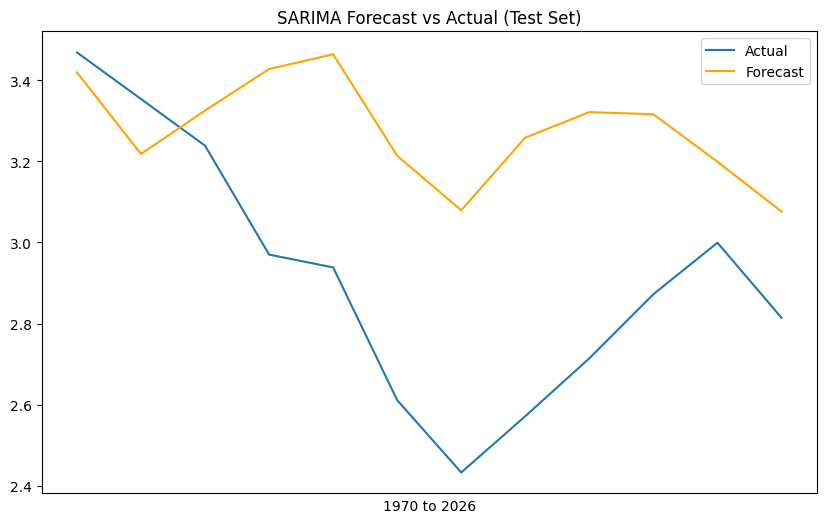

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(predicted.index, predicted, label='Forecast', color='orange')
plt.title("SARIMA Forecast vs Actual (Test Set)")
plt.legend()
plt.show()


From the figure above, the actual inflation start around 3.45%, then trends downward to about 2.4%, before slightly rebounding to nearly 3.0%. On the other hand, the forecast line (orange line) by the model reamins consistenyly above the actual value during the mid-to-late forecast period. The model also misses the depth of the dip in inlflation - it's less responsive to the decline.

MAE: 0.42 - On average, forecasts are 0.42 percentage points off - pretty hight
RMSE 0.44 - Larger errors weigh more heavily
MAPE: 12.47% - On average, forecasts are off by 12% relative to acutal values

Overall, the model forecast starsts close to the actuals, indicating the model is well-calibrated on recent history. On the other hand, the SARIMA smooths over inflections points (missed the steep mid-period drop in inflation)

In [26]:
#transform the data to train for the Random Forest regression model
def create_lag_features(series, lags=12):
    df = pd.DataFrame(series)
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df.iloc[:, 0].shift(lag)
    return df.dropna()

lagged_df = create_lag_features(y, lags = 12)

In [27]:
train = lagged_df.iloc[:-12]
test = lagged_df.iloc[-12:]

X_train = train.drop(columns=[y.name])
y_train = train[y.name]
X_test = test.drop(columns=[y.name])
y_test = test[y.name]

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#define parameter grid
param_grid = {
    'n_estimators': [50,100,200],
    'max_depth': [3,5,10, None],
    'min_samples_split': [2,5,10],
    'min_samples_leaf':[1,2,4]
}

rf = RandomForestRegressor(random_state = 42)

model_rf = GridSearchCV(estimator = rf, param_grid = param_grid, scoring = 'neg_mean_squared_error',
                        cv = 3, n_jobs=-1, verbose =1)

model_rf.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error', verbose=1)

In [34]:
print("Best parameters:", model_rf.best_params_)

# Predict using the best model
y_pred_rf_tuned = model_rf.predict(X_test)

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_rf = mean_absolute_error(y_test, y_pred_rf_tuned)
rmse_rf = mean_squared_error(y_test, y_pred_rf_tuned)
mape_rf = np.mean(np.abs((y_test - y_pred_rf_tuned) / y_test)) * 100

print(f"MAE: {mae_rf:.3f}")
print(f"RMSE: {rmse_rf:.3f}")
print(f"MAPE: {mape_rf:.2f}%")


Best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
MAE: 0.176
RMSE: 0.044
MAPE: 6.23%


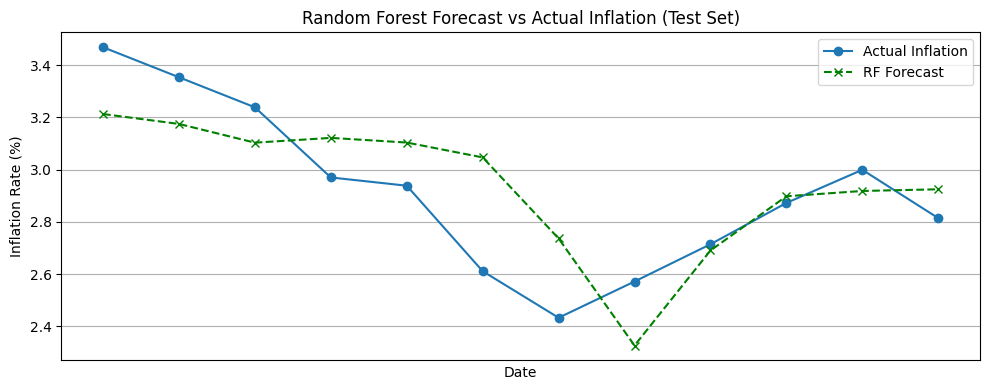

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(y_test.index, y_test, label='Actual Inflation', marker='o')
plt.plot(y_test.index, y_pred_rf_tuned, label='RF Forecast', marker='x', linestyle='--', color='green')
plt.title('Random Forest Forecast vs Actual Inflation (Test Set)')
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [39]:
import pandas as pd

metrics_df = pd.DataFrame({
    'Model': ['SARIMA', 'Random Forest'],
    'MAE': [mae_srm, mae_rf],
    'RMSE': [rmse_srm, rmse_rf],
    'MAPE (%)': [mape_srm, mape_rf]
})

print(metrics_df)


           Model       MAE      RMSE   MAPE (%)
0         SARIMA  0.392196  0.203691  14.308393
1  Random Forest  0.176119  0.044056   6.229528


When we look at the graph, we can clearly see that the model are working really well in term of trying to predict the inflation. However, the model smooths over the sharp dip because it underestimates the downward momentum, then recovers slightly too early.

The Random Forest Regression model lowers forecast errors across all the metrics, especially with MAPE and RMSE. They are also fit on the later part of the series( when the inflation is rising).

Overall conclusion, RFG clearly outperforms SARIMA on this test numerically. It captures directionaily way better thatn SARIMA.